In [2]:
import abacus_cosmos.Halos as ach
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from collections import Counter
import scipy.ndimage as scpimg
import h5py
%matplotlib inline

In [6]:
path = "../data/AbacusCosmos_720box_planck_00_0_rockstar_halos/z0.1/"
L_cell = 2.0
L_box = 720.0
sigma_smooth = 2.0
vmax_cut = 200.0
N_side = np.int(L_box/L_cell)
print(L_box, L_cell, N_side)
output_path = os.path.join(path, "fields")
output_name = "AbacusCosmos_720box_planck_00_0_rockstar"
output_filename = os.path.join(output_path, "velocity_{}_vmax_{}_sigma_{:.1f}_nside_{}.hdf5".format(output_name, vmax_cut, sigma_smooth, N_side))

720.0 2.0 360


In [4]:
halo_data = ach.read_halos_Rockstar(path)
print("Done reading data")

Done reading data


In [9]:
vmax = halo_data['vmax']
ii = (vmax>vmax_cut)
pos_cut = halo_data['pos'][ii]
vel_cut = halo_data['vel'][ii]
print("Done selecting data by vmax")

Done selecting data by vmax


In [15]:
N_side = np.int(L_box/L_cell)
print(L_box, L_cell, N_side, len(pos_cut))
ii = np.int_(pos_cut[:,0]/L_cell)
jj = np.int_(pos_cut[:,1]/L_cell)
kk = np.int_(pos_cut[:,2]/L_cell)

print(np.min(ii), np.max(ii))
print(np.min(jj), np.max(jj))
print(np.min(kk), np.max(kk))

n_grid = np.zeros((N_side, N_side, N_side))

vel_x_grid = np.zeros((N_side, N_side, N_side))
vel_x = vel_cut[:,0]
for i,j,k,t in zip(ii,jj,kk,range(len(vel_x))):
    vel_x_grid[i,j,k] += vel_x[t]
    n_grid[i,j,k] += 1

vel_y_grid = np.zeros((N_side, N_side, N_side))
vel_y = vel_cut[:,1]
for i,j,k,t in zip(ii,jj,kk,range(len(vel_y))):
    vel_y_grid[i,j,k] += vel_y[t]

vel_z_grid = np.zeros((N_side, N_side, N_side))
vel_z = vel_cut[:,2]
for i,j,k,t in zip(ii,jj,kk,range(len(vel_z))):
    vel_z_grid[i,j,k] += vel_z[t]
    
zz = n_grid>0
vel_x_grid[zz] = vel_x_grid[zz]/n_grid[zz]
vel_y_grid[zz] = vel_y_grid[zz]/n_grid[zz]
vel_z_grid[zz] = vel_z_grid[zz]/n_grid[zz]

print("Done NGP interpolation")

720.0 2.0 360 969868
0 359
0 359
0 359
Done NGP interpolation


In [16]:
vel_x_grid_smooth = scpimg.filters.gaussian_filter(vel_x_grid,sigma_smooth)
vel_y_grid_smooth = scpimg.filters.gaussian_filter(vel_y_grid,sigma_smooth)
vel_z_grid_smooth = scpimg.filters.gaussian_filter(vel_z_grid,sigma_smooth)
print("Done Gaussian Smoothing")

Done Gaussian Smoothing


In [40]:
vel_x_grid_smooth_dx = scpimg.filters.correlate1d(vel_x_grid_smooth, [-1,0,1], axis=0, mode='wrap') * (1.0/(2.0*L_cell))
vel_y_grid_smooth_dy = scpimg.filters.correlate1d(vel_y_grid_smooth, [-1,0,1], axis=1, mode='wrap') * (1.0/(2.0*L_cell))
vel_z_grid_smooth_dz = scpimg.filters.correlate1d(vel_z_grid_smooth, [-1,0,1], axis=2, mode='wrap') * (1.0/(2.0*L_cell))
divergence = vel_x_grid_smooth_dx + vel_y_grid_smooth_dy + vel_z_grid_smooth_dz
print("Finished Divergence")


Finished Divergence


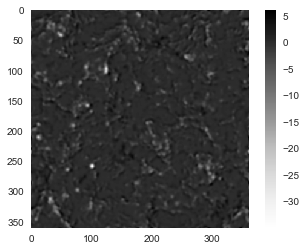

In [43]:
plt.imshow(divergence[:,10,:])
plt.colorbar()
plt.grid(False)

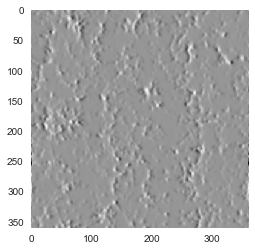

In [39]:
plt.imshow(vel_z_grid_smooth_dz[10,:,:])
plt.grid(False)

In [47]:
output_path = os.path.join(path, "fields")
output_name = "AbacusCosmos_720box_planck_00_0_rockstar"
output_filename = os.path.join(output_path, "velocity_{}_vmax_{}_sigma_{:.1f}_nside_{}.hdf5".format(output_name, vmax_cut, sigma_smooth, N_side))
print(output_filename)
h5f = h5py.File(output_filename, 'w')
h5f.create_dataset('vel_x', data=vel_x_grid_smooth)
h5f.create_dataset('vel_y', data=vel_y_grid_smooth)
h5f.create_dataset('vel_z', data=vel_z_grid_smooth)
h5f.create_dataset('divergence', data=divergence)
h5f.close()

../data/AbacusCosmos_720box_planck_00_0_rockstar_halos/z0.1/fields/velocity_AbacusCosmos_720box_planck_00_0_rockstar_vmax_200.0_sigma_2.0_nside_360.hdf5


In [7]:
f = h5py.File(output_filename, 'r')
print(f.keys())
divergence = f['divergence'][:,:,:]
vel_x = f['vel_x'][:,:,:]
vel_y = f['vel_y'][:,:,:]
vel_z = f['vel_z'][:,:,:]
f.close()

<KeysViewHDF5 ['divergence', 'vel_x', 'vel_y', 'vel_z']>


Text(0,0.5,'log 10 Velocity Magnitude/kms')

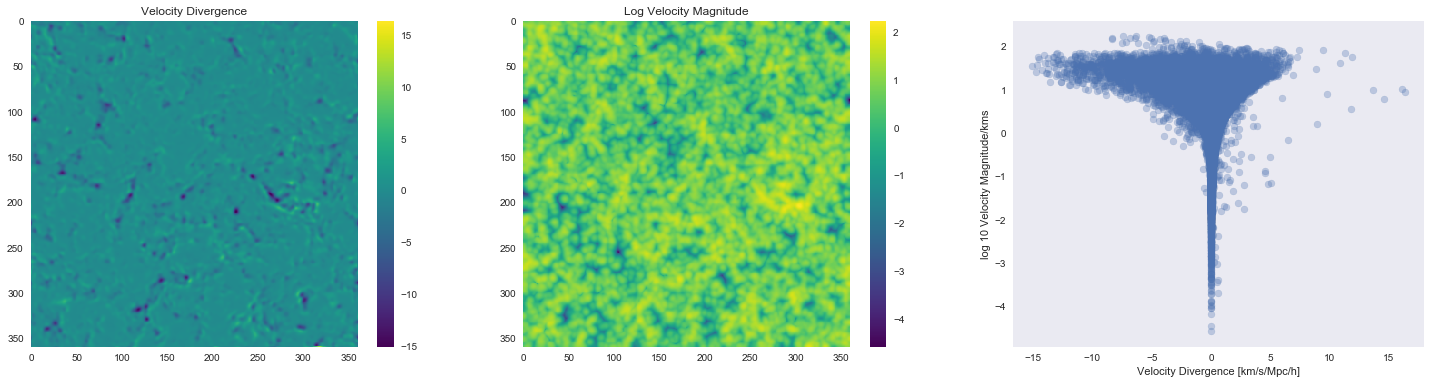

In [22]:
plt.figure(figsize=(25,6))
slice_id=300

plt.subplot(1,3,1)
plt.imshow(divergence[slice_id,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar()
plt.title('Velocity Divergence')


plt.subplot(1,3,2)
norm_vel = np.sqrt(vel_x**2 + vel_y**2 + vel_z**2)
plt.imshow(np.log10(norm_vel[slice_id,:,:]), cmap='viridis')
plt.grid(False)
plt.colorbar()
plt.title('Log Velocity Magnitude')

plt.subplot(1,3,3)
plt.scatter(divergence[slice_id,:,:].flatten(), np.log10(norm_vel[slice_id,:,:].flatten()), alpha=0.3)
plt.grid(False)
plt.xlabel('Velocity Divergence [km/s/Mpc/h]')
plt.ylabel('log 10 Velocity Magnitude/kms')

In [ ]:
dat
full_computation = True
if full_computation:
    path = "../data/AbacusCosmos_720box_planck_00_0_rockstar_halos/z0.1/"
    L_cell = 2.0
    for sigma_smooth in [1.0]:
        for sigma_cut in [200.0]:
            smooth_data(path, L_cell=L_cell, sigma_cut=sigma_cut, sigma_smooth=sigma_smooth)

In [ ]:
sd